# Unity ML Agents
## Environment Basics
This notebook contains a walkthrough of the basic functions of the Python API for Unity ML Agents. For instructions on building a Unity environment, see [here](https://github.com/Unity-Technologies/ml-agents/wiki/Getting-Started-with-Balance-Ball).

### 1. Load dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import random
import datetime
import os
import time

from unityagents import UnityEnvironment

%matplotlib inline

### 2. Set environment parameters

Be sure to set `env_name` to the name of the Unity environment file you want to launch.

In [2]:
env_name = "../environment/jeju_camp" # Name of the Unity environment binary to launch
train_mode = True # Whether to run the environment in training or inference mode

### 3. Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: Brain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 368
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 5
        Vector Action descriptions: , , , , 


Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: Brain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 368
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 5
        Vector Action descriptions: , , , , 


### 4. Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

Agent state looks like: 
[ 1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          0.9755246   0.91600198  0.86357307  0.81705666  0.77551937
  0.73821479  0.70453942  0.67399871  0.64618438  0.62075633  0.59742886
  0.57596022  0.5561446   0.53780544  0.52079082  0.50496876  0.49022466
  0.47645816  0.46358114  0.45151567  0.44019303  0.42955208  0.41953811
  0.41010255  0.40120158  0.39279586  0.38485005  0.37733197  0.37021253
  0.36346549  0.35706681  0.35099453  0.34522879  0.33975118  0.33454502
  0.32959491  0.32488668  0.32040724  0.31614468  0.31208783  0.30822647
  0.30455115  0.30105308  0.29772413  0.29455668  0.29154381  0.288679
  0.28595623  0.28336981  0.2809146   0.27858567  0.27637851  0.27428898
  0.27231315  0.27044734  0.26868826  0.26703268  0.26547778  0.26402083
  0.26265934  0.26139107  0.26021382  0.25912577  0.25812501  0.25721005
  0.25637937  0.2556

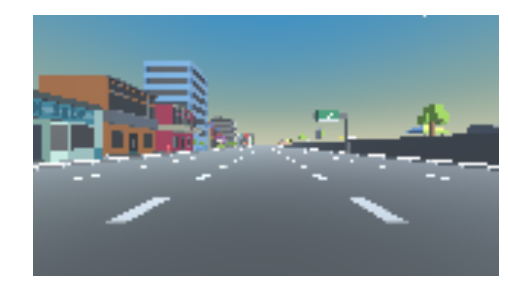

In [4]:
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]

# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.vector_observations[0]))

# Examine the observation space for the default brain
Num_obs = len(env_info.visual_observations)

print("Agent observations look like:")
if Num_obs > 1:
    f, axarr = plt.subplots(1, Num_obs, figsize=(20,10))
    for i, observation in enumerate(env_info.visual_observations):
        if observation.shape[3] == 3:
            axarr[i].imshow(observation[0,:,:,:])
            axarr[i].axis('off')
        else:
            axarr[i].imshow(observation[0,:,:,0])
            axarr[i].axis('off')
else:
    f, axarr = plt.subplots(1, Num_obs)
    for i, observation in enumerate(env_info.visual_observations):
        if observation.shape[3] == 3:
            axarr.imshow(observation[0,:,:,:])
            axarr.axis('off')
        else:
            axarr.imshow(observation[0,:,:,0])
            axarr.axis('off')

### 5. Parameters

In [5]:
import random

Gamma = 0.99
Learning_rate = 0.00025

algorithm = 'DDuelingDQN'
Num_action = brain.vector_action_space_size

Num_replay_memory = 100000
Num_start_training = 50000
Num_training = 1000000
Num_update = 10000
Num_batch = 32
Num_test = 100000
Num_skipFrame = 4
Num_stackFrame = 4
Num_colorChannel = 1

Num_dataSize = 366
Num_cellState = 512

Epsilon = 1.0
Final_epsilon = 0.1

Num_plot_episode = 5
Num_step_save = 50000

GPU_fraction = 0.3

img_size = 80
sensor_size = 360

first_conv   = [8,8,Num_colorChannel * Num_stackFrame * Num_obs,32]
second_conv  = [4,4,32,64]
third_conv   = [3,3,64,64]
first_dense  = [Num_cellState, 512]
dense_state_sensor  = [first_dense[1], 1]
dense_action_sensor = [first_dense[1], Num_action]

train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]

score_list = []
check_show_progress = 0

load_path = '../saved_networks/2018-05-01_0_20_DDuelingDQN_sensor/model.ckpt'

### Functions for Networks

In [6]:
# Initialize weights and bias
def weight_variable(shape):
    return tf.Variable(xavier_initializer(shape))

def bias_variable(shape):
	return tf.Variable(xavier_initializer(shape))

def mu_variable(shape):
    return tf.Variable(tf.random_uniform(shape, minval = -tf.sqrt(3/shape[0]), maxval = tf.sqrt(3/shape[0])))

def sigma_variable(shape):
	return tf.Variable(tf.constant(0.017, shape = shape))

# Xavier Weights initializer
def xavier_initializer(shape):
	dim_sum = np.sum(shape)
	if len(shape) == 1:
		dim_sum += 1
	bound = np.sqrt(2.0 / dim_sum)
	return tf.random_uniform(shape, minval=-bound, maxval=bound)

# Convolution and pooling
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
	return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def assign_network_to_target():
	# Get trainable variables
	trainable_variables = tf.trainable_variables()
	# network lstm variables
	trainable_variables_network = [var for var in trainable_variables if var.name.startswith('network')]

	# target lstm variables
	trainable_variables_target = [var for var in trainable_variables if var.name.startswith('target')]

	for i in range(len(trainable_variables_network)):
		sess.run(tf.assign(trainable_variables_target[i], trainable_variables_network[i]))

# Code for tensorboard
def setup_summary():
    episode_speed      = tf.Variable(0.)
    episode_overtake   = tf.Variable(0.)
    episode_lanechange = tf.Variable(0.)

    tf.summary.scalar('Average_Speed/' + str(Num_plot_episode) + 'episodes', episode_speed)
    tf.summary.scalar('Average_overtake/' + str(Num_plot_episode) + 'episodes', episode_overtake)
    tf.summary.scalar('Average_lanechange/' + str(Num_plot_episode) + 'episodes', episode_lanechange)

    summary_vars = [episode_speed, episode_overtake, episode_lanechange]
    summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
    update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
    summary_op = tf.summary.merge_all()
    return summary_placeholders, update_ops, summary_op

### Network

In [7]:
tf.reset_default_graph()

# Input
x_image = tf.placeholder(tf.float32, shape = [None, img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs])
x_normalize = (x_image - (255.0/2)) / (255.0/2)

x_sensor = tf.placeholder(tf.float32, shape = [None, Num_stackFrame, Num_dataSize])
x_unstack = tf.unstack(x_sensor, axis = 1)

with tf.variable_scope('network'):
    # LSTM cell
    cell = tf.contrib.rnn.BasicLSTMCell(num_units = Num_cellState)            
    rnn_out, rnn_state = tf.nn.static_rnn(inputs = x_unstack, cell = cell, dtype = tf.float32)
    
    # Densely connect layer variables
    w_fc1_1 = weight_variable(first_dense)
    b_fc1_1 = bias_variable([first_dense[1]])

    w_fc1_2 = weight_variable(first_dense)
    b_fc1_2 = bias_variable([first_dense[1]])

    w_fc2_1 = weight_variable(dense_state_sensor)
    b_fc2_1 = bias_variable([dense_state_sensor[1]])

    w_fc2_2 = weight_variable(dense_action_sensor)
    b_fc2_2 = bias_variable([dense_action_sensor[1]])
    
# Network
rnn_out = rnn_out[-1]

h_fc1_state  = tf.matmul(rnn_out, w_fc1_1) + b_fc1_1
h_fc1_action = tf.matmul(rnn_out, w_fc1_2) + b_fc1_2

h_fc2_state  = tf.matmul(h_fc1_state, w_fc2_1) + b_fc2_1
h_fc2_action = tf.matmul(h_fc1_action, w_fc2_2) + b_fc2_2

h_fc2_advantage = tf.subtract(h_fc2_action, tf.reduce_mean(h_fc2_action))

output = tf.add(h_fc2_state, h_fc2_advantage)

with tf.variable_scope('target'):
    
    # LSTM cell
    cell_target = tf.contrib.rnn.BasicLSTMCell(num_units = Num_cellState)            
    rnn_out_target, rnn_state_target = tf.nn.static_rnn(inputs = x_unstack, cell = cell_target, dtype = tf.float32)
    
    # Densely connect layer variables
    w_fc1_1_target = weight_variable(first_dense)
    b_fc1_1_target = bias_variable([first_dense[1]])

    w_fc1_2_target = weight_variable(first_dense)
    b_fc1_2_target = bias_variable([first_dense[1]])
    
    w_fc2_1_target = weight_variable(dense_state_sensor)
    b_fc2_1_target = bias_variable([dense_state_sensor[1]])

    w_fc2_2_target = weight_variable(dense_action_sensor)
    b_fc2_2_target = bias_variable([dense_action_sensor[1]])

rnn_out_target = rnn_out_target[-1]

h_fc1_state_target  = tf.matmul(rnn_out_target, w_fc1_1_target) + b_fc1_1_target
h_fc1_action_target = tf.matmul(rnn_out_target, w_fc1_2_target) + b_fc1_2_target

h_fc2_state_target  = tf.matmul(h_fc1_state_target, w_fc2_1_target) + b_fc2_1_target
h_fc2_action_target = tf.matmul(h_fc1_action_target, w_fc2_2_target) + b_fc2_2_target

h_fc2_advantage_target = tf.subtract(h_fc2_action_target, tf.reduce_mean(h_fc2_action_target))

output_target = tf.add(h_fc2_state_target, h_fc2_advantage_target)

### Loss

In [8]:
# Loss function and Train
action_target = tf.placeholder(tf.float32, shape = [None, Num_action])
y_target = tf.placeholder(tf.float32, shape = [None])

y_prediction = tf.reduce_sum(tf.multiply(output, action_target), reduction_indices = 1)
Loss = tf.reduce_mean(tf.square(y_prediction - y_target))
train_step = tf.train.AdamOptimizer(learning_rate = Learning_rate, epsilon = 1e-02).minimize(Loss)

### Config

In [9]:
## Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = GPU_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Training or Inference

In [10]:
# Load the file if the saved file exists
saver = tf.train.Saver()

# check_save = 1
check_save = input('Inference? / Training?(1=Inference/2=Training): ')

if check_save == '1':
    # Directly start inference
    Num_start_training = 0
    Num_training = 0
    
    # Restore variables from disk.
    saver.restore(sess, load_path)
    print("Model restored.")

# date - hour - minute of training time
date_time = str(datetime.date.today()) + '_' + str(datetime.datetime.now().hour) + '_' + str(datetime.datetime.now().minute)

# Make folder for save data
os.makedirs('../saved_networks/' + date_time + '_' + algorithm + '_sensor')

# Summary for tensorboard
summary_placeholders, update_ops, summary_op = setup_summary()
summary_writer = tf.summary.FileWriter('../saved_networks/' + date_time + '_' + algorithm + '_sensor', sess.graph)

Inference? / Training?(1=Inference/2=Training): 2


### Functions for Training

In [11]:
def state_initialization(env_info):    
    state = env_info.vector_observations[0][:-2]

    state_set = []

    for i in range(Num_skipFrame * Num_stackFrame):
        state_set.append(state)
    
    # Stack the frame according to the number of skipping and stacking frames using observation set
    state_stack = np.zeros((Num_stackFrame, Num_dataSize))
    for stack_frame in range(Num_stackFrame):
        state_stack[(Num_stackFrame - 1) - stack_frame, :] = state_set[-1 - (Num_skipFrame * stack_frame)]

    state_stack = np.uint8(state_stack)

    return state_stack, state_set

def resize_state(env_info, state_set):
    state = env_info.vector_observations[0][:-2]

    # Add state to the state_set
    state_set.append(state)
    
    # Stack the frame according to the number of skipping and stacking frames using observation set
    state_stack = np.zeros((Num_stackFrame, Num_dataSize))
    for stack_frame in range(Num_stackFrame):
        state_stack[(Num_stackFrame - 1) - stack_frame, :] = state_set[-1 - (Num_skipFrame * stack_frame)]
        
    del state_set[0]

    state_stack = np.uint8(state_stack)
    
    return state_stack, state_set

# Get progress according to the 
def get_progress(step, Epsilon):
    if step <= Num_start_training:
        # Observation
        progress = 'Observing'
        train_mode = True
        Epsilon = 1

    elif step <= Num_start_training + Num_training:
        # Training
        progress = 'Training'
        train_mode = True
        
        # Decrease the epsilon value
        if Epsilon > Final_epsilon:
            Epsilon -= 1.0/Num_training
        
    elif step < Num_start_training + Num_training + Num_test:
        # Testing
        progress = 'Testing'
        train_mode = False
        Epsilon = 0

    else:
        # Finished
        progress = 'Finished'
        train_mode = False
        Epsilon = 0
        
    return progress, train_mode, Epsilon 

# Select action according to the progress of training
def select_action(progress, sess, state_stack, Epsilon):
    if progress == "Observing":
        Q_value = 0
        action = np.zeros([Num_action])
        action[random.randint(0, Num_action - 1)] = 1.0
    elif progress == "Training":
        # if random value(0 - 1) is smaller than Epsilon, action is random. Otherwise, action is the one which has the largest Q value
        if random.random() < Epsilon:
            Q_value = 0
            action = np.zeros([Num_action])
            action[random.randint(0, Num_action - 1)] = 1
        else:
            Q_value = output.eval(feed_dict={x_sensor: [state_stack]})
            action = np.zeros([Num_action])
            action[np.argmax(Q_value)] = 1
    else:
        Q_value = output.eval(feed_dict={x_sensor: [state_stack]})
        action = np.zeros([Num_action])
        action[np.argmax(Q_value)] = 1
        
    return action, Q_value

def train(Replay_memory, sess, step):
    # Select minibatch
    minibatch =  random.sample(Replay_memory, Num_batch)

    # Save the each batch data
    state_batch      = [batch[0] for batch in minibatch]
    action_batch     = [batch[1] for batch in minibatch]
    reward_batch     = [batch[2] for batch in minibatch]
    state_next_batch = [batch[3] for batch in minibatch]
    terminal_batch 	 = [batch[4] for batch in minibatch]

    # Update target network according to the Num_update value
    if step % Num_update == 0:
        assign_network_to_target()
    
    ####################################### Double Q Learning part #######################################
    # Get target values
    y_batch = []
    # Selecting actions
    Q_network = output.eval(feed_dict = {x_sensor: state_next_batch})

    a_max = []
    for i in range(Q_network.shape[0]):
        a_max.append(np.argmax(Q_network[i]))

    # Evaluation
    Q_target = output_target.eval(feed_dict = {x_sensor: state_next_batch})
    for i in range(len(minibatch)):
        if terminal_batch[i] == True:
            y_batch.append(reward_batch[i])
        else:
            y_batch.append(reward_batch[i] + Gamma * Q_target[i, a_max[i]])

    _, loss = sess.run([train_step, Loss], feed_dict = {action_target: action_batch, 
                                                        y_target: y_batch,
                                                        x_sensor: state_batch})
    ######################################################################################################

# Experience Replay 
def Experience_Replay(progress, Replay_memory, state_stack, action, reward, next_state_stack, terminal):
    if progress != 'Testing':
        # If length of replay memeory is more than the setting value then remove the first one
        if len(Replay_memory) > Num_replay_memory:
            del Replay_memory[0]

        # Save experience to the Replay memory
        Replay_memory.append([state_stack, action, reward, next_state_stack, terminal])
    else:
        # Empty the replay memory if testing
        Replay_memory = []
    
    return Replay_memory

### Initialize Variables

In [12]:
# Initial parameters
Replay_memory = []

step = 1
score = 0
score_board = 0

episode = 0
step_per_episode = 0

speed_list = []
overtake_list = []
lanechange_list = []

train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]

state_stack, state_set = state_initialization(env_info)

### Training

In [13]:
check_plot = 0

# Training & Testing
while True:
    
    # Get Progress, train mode
    progress, train_mode, Epsilon  = get_progress(step, Epsilon)
    
    # Select Actions 
    action, Q_value = select_action(progress, sess, state_stack, Epsilon)
    action_in = [np.argmax(action)]
    
    # Get information for plotting
    vehicle_speed  = 100 * env_info.vector_observations[0][-3]
    num_overtake   = env_info.vector_observations[0][-2]
    num_lanechange = env_info.vector_observations[0][-1]
    
    # Get information for update
    env_info = env.step(action_in)[default_brain]

    next_state_stack, state_set = resize_state(env_info, state_set) 
    reward = env_info.rewards[0]
    terminal = env_info.local_done[0]
    
    if progress == 'Training':
        # Train!! 
        train(Replay_memory, sess, step)

        # Save the variables to disk.
        if step == Num_start_training + Num_training:
            save_path = saver.save(sess, '../saved_networks/' + date_time + '_' + algorithm + '_sensor' + "/model.ckpt")
            print("Model saved in file: %s" % save_path)
    
    # If progress is finished -> close! 
    if progress == 'Finished':
        print('Finished!!')
        env.close()
        break
        
    Replay_memory = Experience_Replay(progress, 
                                      Replay_memory, 
                                      state_stack,
                                      action, 
                                      reward, 
                                      next_state_stack,
                                      terminal)
    
    # Update information
    step += 1
    score += reward
    step_per_episode += 1
    state_stack = next_state_stack
    
    # Update tensorboard
    if progress != 'Observing':
        speed_list.append(vehicle_speed)
        
        if episode % Num_plot_episode == 0 and check_plot == 1 and episode != 0:
            avg_speed      = sum(speed_list) / len(speed_list)
            avg_overtake   = sum(overtake_list) / len(overtake_list)
            avg_lanechange = sum(lanechange_list) / len(lanechange_list)
            
            tensorboard_info = [avg_speed, avg_overtake, avg_lanechange]
            for i in range(len(tensorboard_info)):
                sess.run(update_ops[i], feed_dict = {summary_placeholders[i]: float(tensorboard_info[i])})
            summary_str = sess.run(summary_op)
            summary_writer.add_summary(summary_str, step)
            score_board = 0
            
            speed_list = []
            overtake_list = []
            lanechange_list = []

            check_plot = 0
            
    # If terminal is True
    if terminal == True:
        # Print informations
        print('step: ' + str(step) + ' / '  + 'episode: ' + str(episode) + ' / ' + 'progress: ' + progress  + ' / ' + 'epsilon: ' + str(Epsilon)  +' / ' + 'score: ' + str(score))

        check_plot = 1

        if progress != 'Observing':
            episode += 1
            
            score_board += score
            overtake_list.append(num_overtake)
            lanechange_list.append(num_lanechange)
        
            
        score = 0
        step_per_episode = 0

        # Initialize game state
        env_info = env.reset(train_mode=train_mode)[default_brain]
        state_stack, state_set = state_initialization(env_info)

        



step: 4637 / episode: 0 / progress: Observing / epsilon: 1 / score: 1270.405526600778
step: 5727 / episode: 0 / progress: Observing / epsilon: 1 / score: 178.76136755943298
step: 8929 / episode: 0 / progress: Observing / epsilon: 1 / score: 982.2700320929289
step: 13475 / episode: 0 / progress: Observing / epsilon: 1 / score: 1423.9382626712322
step: 17865 / episode: 0 / progress: Observing / epsilon: 1 / score: 1468.6395016387105
step: 21909 / episode: 0 / progress: Observing / epsilon: 1 / score: 857.6614707037807
step: 26282 / episode: 0 / progress: Observing / epsilon: 1 / score: 1620.1226575300097
step: 30842 / episode: 0 / progress: Observing / epsilon: 1 / score: 1378.2962151393294
step: 34523 / episode: 0 / progress: Observing / epsilon: 1 / score: 1181.7433804348111
step: 38949 / episode: 0 / progress: Observing / epsilon: 1 / score: 1494.825693950057
step: 43631 / episode: 0 / progress: Observing / epsilon: 1 / score: 1108.9867897108197
step: 47256 / episode: 0 / progress: Ob

In [14]:
env.close()